# Clustering LIME and SHAP Regression

The objective of this notebook is to verify the algorithmic explanation consistency framework for the regression case. Thus, we will follow the same procedure as before - perform a descriptive analysis on the data, fit a model (LightGBM) and perform predictions. Thereafter, we will generate the explanations for the predictions for Shapley and for Lime and then finally check apply the consistency framework to the results and analyse the findings.

In [1]:
#Import packages & Setup
import numpy as np #Linear Algebra
import pandas as pd #Data Frames / Analysis / Structuring / Import
import seaborn as sns #Plotting
sns.set_style('darkgrid')
import matplotlib.pyplot as plt #Plotting and using inline to not always repeat plt.show() statement
from matplotlib import colors
%matplotlib inline

# Overview

- [Data Import & Preparation](#Data-Import-&-Preparation)<p></p>
    - [Descriptive Analysis](#Descriptive-Analysis)<p></p>
    - [Graphical Analysis](#Graphical-Analysis)<p></p>
- [Prediction Model](#Prediction-Model)<p></p>
    - [XGBoost Fitting](#XGBoost-Fitting)<p></p>
    - [XGBoost Evaluation](#XGBoost-Evaluation)<p></p>
    - [LightGBM Fitting](#LightGBM-Fitting)<p></p>
    - [LightGBM Evaluation](#LightGBM-Evaluation)<p></p>
- [Explanation Models](#Explanation-Models)<p></p>
    - [LIME](#LIME)<p></p>
    - [SHAP](#SHAP)<p></p>
- [Algorithmic Explanation Consistency](#Algorithmic-Explanation-Consistency)<p></p>
    - [LIME Evaluation](#LIME-Evaluation)<p></p>
    - [SHAP Evaluation](#SHAP-Evaluation)<p></p>
    - [AEC Heuristic](#AEC-Heuristic)<p></p>

## Data Import & Preparation
[[Back to the top]](#Overview)

Dataset: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. It's a great dataset for evaluating simple regression models.
<br><b>Source:</b> https://www.kaggle.com/harlfoxem/housesalesprediction

In [2]:
#Importing Data
file = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\kc_house_data.csv' #Path
data = pd.read_csv(file,
                           delimiter = ',',
                           parse_dates = ['date'],
                           error_bad_lines = True, #Skip Rows with errors
                           nrows = 1000000 #nrows = number of rows to import (to limit import size
                          )
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,2014-10-15,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


### Descriptive Analysis
[[Back to the top]](#Overview)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


In [5]:
data.duplicated().value_counts()

False    21613
dtype: int64

There is a total of 21 columns and 21.613 objects (data points), with no null-values and no duplicates.

In [6]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
data['date'].describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

In [8]:
data['date'].dt.weekday_name.value_counts()

Tuesday      4715
Wednesday    4603
Monday       4099
Thursday     3994
Friday       3685
Saturday      287
Sunday        230
Name: date, dtype: int64

### Graphical Analysis
[[Back to the top]](#Overview)

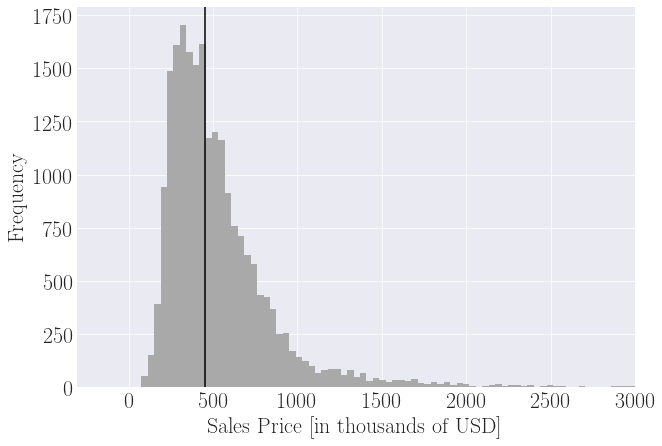

In [9]:
#Import ticker to change xticks format to thousands of...
from matplotlib import ticker as ticker

#Define the size of the plot
plt.rcParams['figure.figsize'] = (10, 7)

#Adjusting the Writing size
plt.rcParams.update({'font.size': 22})

#Adjusting the Fonts to be able to use Latex, Note: Latex must be installed for this to work
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

#Create the Plot
fig, ax = plt.subplots()

#Create the Histogram in the Plot
ax.hist(data.price, bins = 200, color = 'darkgray')

#Adjust the x-ticks in the plot to thousands unit
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '%.0f' % (y * 1e-3)))

#Cut the graph at 3M on x-axis
plt.xlim(None, 3000000)

#Add a vertical line to the graph at median value of the price
plt.axvline(x = 450000, color = 'black') #Median

#Add Axis titles
plt.ylabel('Frequency') # ,fontsize = 18
plt.xlabel('Sales Price [in thousands of USD]')

#plt.savefig('Sales_Price_Distribution_in_King_County.png', dpi = 200, bbox_inches = 'tight', format = 'png')

plt.show()

As we can see on the graph above, the price data is heavily skewed, so we will apply a log-transformation, which if the data are log-normally distributed, the log transformation makes them normally distributed, which is a much wanted distribution.

Text(0,0.5,'#Sales')

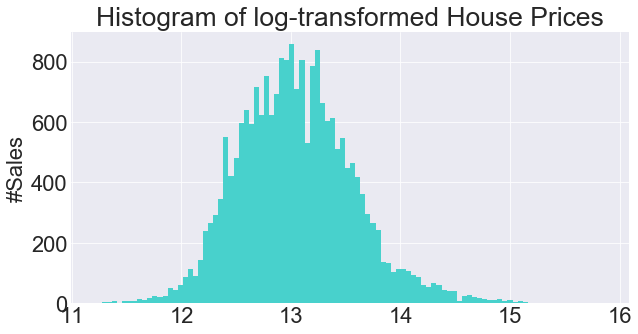

In [10]:
#Resetting Tex Formatting
plt.rc('text', usetex = False)
sns.set_style('darkgrid')
#plt.rcParams['font.size'] = 12

#Addding a column for log-transformed prices in our dataframe
data['log_price'] = np.log(data['price'])

#Plotting a Histogram of log-transformed prices
plt.rcParams['figure.figsize'] = (10, 5)
plt.hist(data['log_price'], bins = 100, color = 'mediumturquoise')
plt.title('Histogram of log-transformed House Prices')
plt.ylabel('#Sales')

Text(0,0.5,'#Sales')

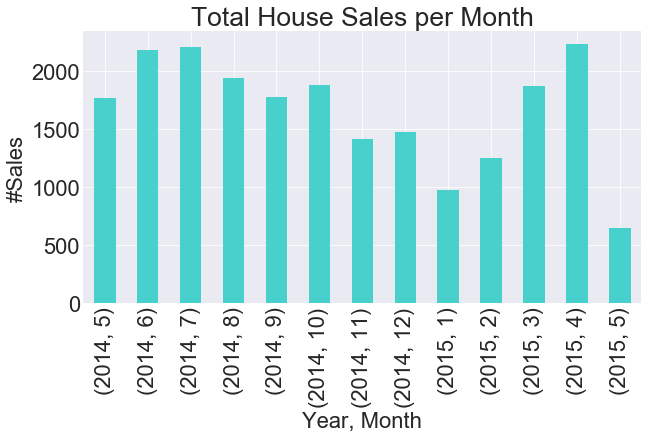

In [11]:
plt.rcParams['figure.figsize'] = (10, 5)
data.groupby([data['date'].dt.year, data['date'].dt.month]).count()['id'].plot(kind='bar', color = 'mediumturquoise')
plt.title('Total House Sales per Month')
plt.xlabel('Year, Month')
plt.ylabel('#Sales')
#plt.rcParams['font.size'] = 12

Text(0.5,1,'Price')

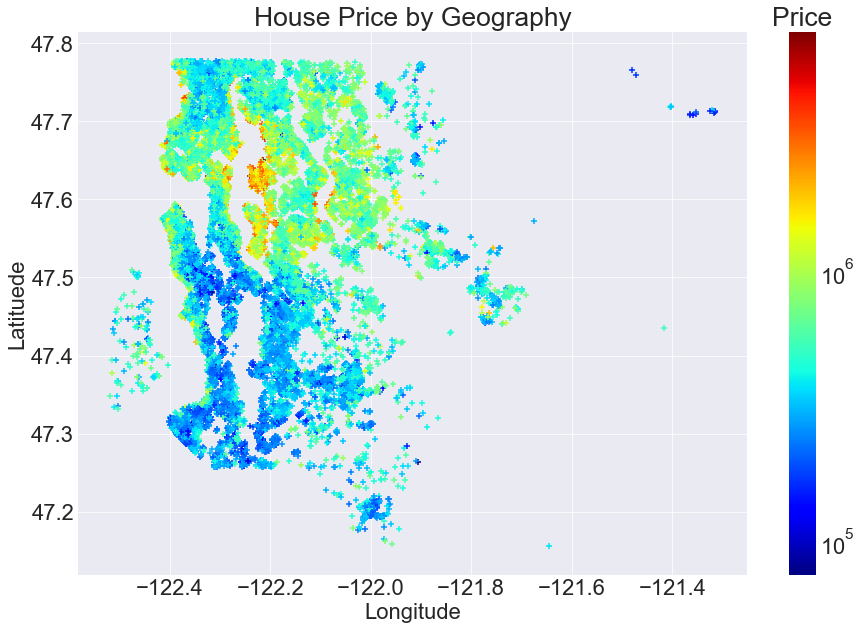

In [12]:
plt.figure(figsize = (15,10))
min_price = np.min(data.price)
max_price = np.max(data.price)
log_prices = colors.LogNorm(min_price, max_price)
plt.scatter(data.long, data.lat, marker = '+', c = data.price, norm = log_prices,cmap='jet') 
plt.xlabel('Longitude')
plt.ylabel('Latituede')
plt.title('House Price by Geography')
clb = plt.colorbar() 
clb.ax.set_title('Price')

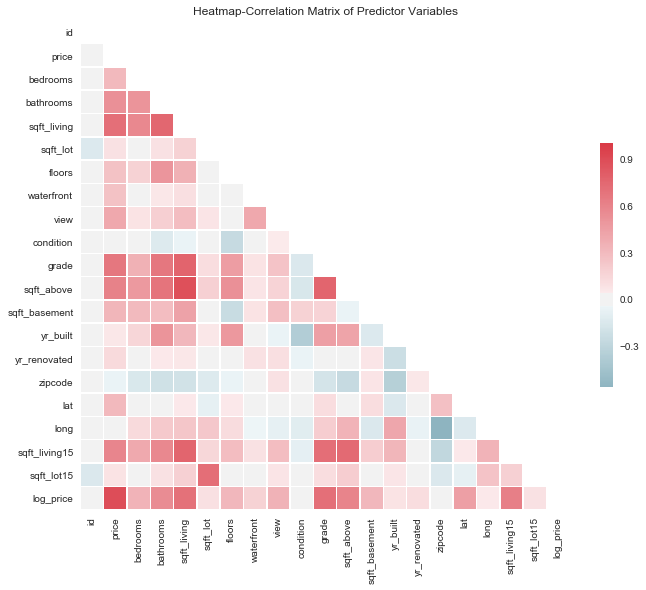

In [13]:
#Computing the visualization of the Correlation Matrix
from string import ascii_letters
import seaborn as sns

sns.set(style = "white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)
plt.title('Heatmap-Correlation Matrix of Predictor Variables')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

As we can se ein the graph above, mainly sqft_living15, sqft_lot15 and sqft_above are correlated variables, so we will possibly drop those for the prediction model.

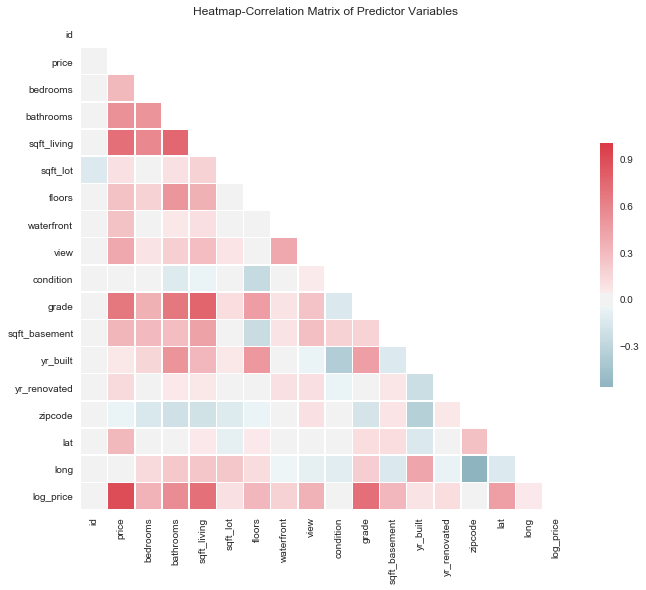

In [14]:
sns.set(style = "white")

# Compute the correlation matrix
corr = data.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)
plt.title('Heatmap-Correlation Matrix of Predictor Variables')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

## Prediction Model
[[Back to the top]](#Overview)

We will try out two different models in the following: First we will use the XGBoost model (TreeRegressor) and after, we will also use the MLP from SKLearn with a regression output.

### XGBoost Fitting
[[Back to the top]](#Overview)

In [15]:
duplicates_list = data[data.drop(['id','date','price', 'log_price', 'sqft_living15','sqft_lot15'], axis = 1).duplicated()].index

In [16]:
data = data.drop(data.index[duplicates_list])
data = data.reset_index(drop = True)
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
21415,2997800021,2015-02-19,475000.0,3,2.50,1310,1294,2.0,0,0,...,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,13.071070
21416,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,12.899220
21417,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,12.904459
21418,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,12.899220
21419,1523300157,2014-10-15,325000.0,2,0.75,1020,1076,2.0,0,0,...,1020,0,2008,0,98144,47.5941,-122.299,1020,1357,12.691580


In [17]:
#Selecting the columns to fit the model 
train = data.drop(['id','date','price', 'log_price', 'sqft_living15','sqft_lot15'], axis = 1) #'sqft_living15','sqft_lot15','sqft_living'
labels = data['price']

#Performing a Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size = 0.25, shuffle = True, random_state = 7)

In [18]:
train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'],
      dtype='object')

In [19]:
len(train.columns)

16

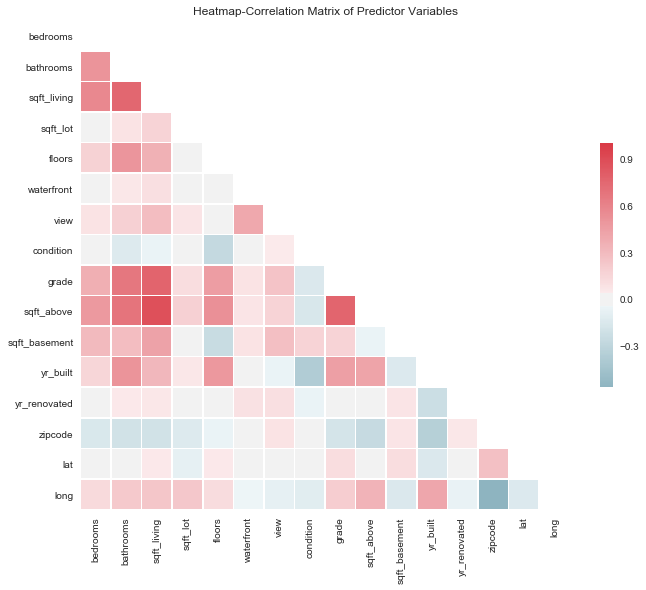

In [20]:
sns.set(style = "white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)
plt.title('Heatmap-Correlation Matrix of Predictor Variables')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

In [21]:
train.tail()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
21415,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409
21416,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362
21417,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299
21418,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069
21419,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299


In [22]:
train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000
mean,3.372035,2.117075,2083.010831,1.514540e+04,1.495658,0.007610,0.235294,3.410644,7.661531,1791.170261,291.840570,1971.070495,84.793091,98077.863119,47.560177,-122.213675
std,0.929321,0.770091,919.366820,4.155258e+04,0.540122,0.086903,0.767352,0.650375,1.174493,829.222921,442.872088,29.377572,402.574626,53.474725,0.138628,0.140897
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.471100,-122.328000
50%,3.000000,2.250000,1920.000000,7.617000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572100,-122.230000
75%,4.000000,2.500000,2550.000000,1.070125e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.124000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000


In [23]:
data["price"].describe()

count    2.142000e+04
mean     5.406074e+05
std      3.677816e+05
min      7.500000e+04
25%      3.224750e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [24]:
xgb_params = {
    'objective': 'reg:linear',
    'eta': 0.10,
    'eval_metric': 'rmse',
    'max_depth': 5,
    'min_child_weight': 3,
    'subsample' : 0.8,
    'colsample_bytree': 0.8,
    'silent': 1,
    'seed': 7
}

In [25]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

In [26]:
xgboost_model = xgb.train(xgb_params,
                          dtrain,
                          num_boost_round = 100, #corresponds to n_estimators
                         )

### XGBoost Evaluation
[[Back to the top]](#Overview)

<b>Assessing the accuracy on training data:

In [27]:
xgb_y_train_pred = xgboost_model.predict(dtrain)

In [28]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train,xgb_y_train_pred))

92123.68972461326

In [29]:
from sklearn.metrics import r2_score
r2_score(y_train, xgb_y_train_pred)

0.9373174327392454

<b>Assessing the accuracy on testing data:

In [30]:
xgb_y_test_pred = xgboost_model.predict(dvalid)

In [31]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, xgb_y_test_pred))

120478.06115543241

In [32]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_y_test_pred)

0.8923593667278644

In [33]:
pd.options.display.float_format = '{:.1f}'.format
results = pd.DataFrame(y_test)
results['predicted'] = xgb_y_test_pred
results.head()

,price,predicted
19320,370000.0,350922.8
16040,264500.0,273265.9
8731,630000.0,589958.8
2096,989000.0,1043276.8
4179,525000.0,556156.9


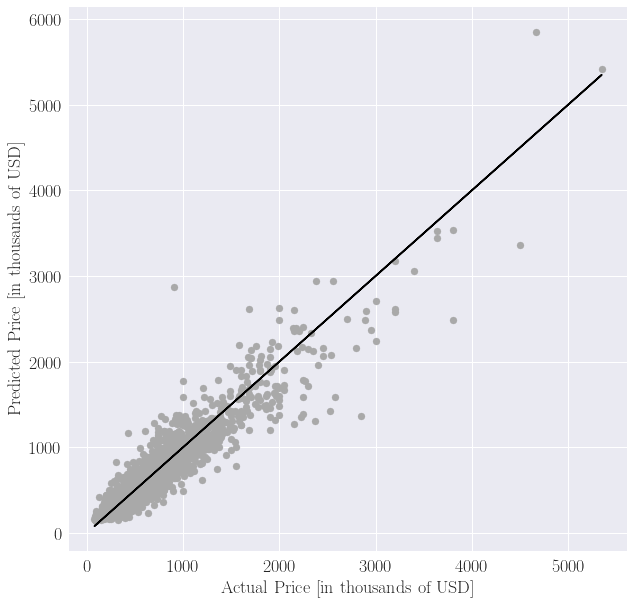

In [34]:
#Define the size of the plot
plt.rcParams['figure.figsize'] = (10, 10)
sns.set_style('darkgrid')

#Adjusting the Fonts to be able to use Latex, Note: Latex must be installed for this to work
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

#Create the Plot
fig, ax = plt.subplots()

#Adjusting the Writing size
plt.rcParams.update({'font.size': 22})

#Create the Histogram in the Plot
ax.scatter(y_test, xgb_y_test_pred, color = 'darkgray')

#Add a diagonal line that represents the perfect prediction model
plt.plot(y_test,y_test,'k-') # identity line

#Adjust the x-ticks in the plot to thousands unit
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '%.0f' % (y * 1e-3)))

#Adjust the y-ticks in the plot to thousands unit
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '%.0f' % (y * 1e-3)))

#Add Axis titles
plt.xlabel('Actual Price [in thousands of USD]', fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Predicted Price [in thousands of USD]', fontsize = 18) # ,fontsize = 18
plt.yticks(fontsize = 18)


#plt.savefig('House_Prices_Actual_Vs_Predicted.png', dpi = 200, bbox_inches = 'tight', format = 'png')

plt.show()

#Resetting Tex Formatting
plt.rc('text', usetex = False)

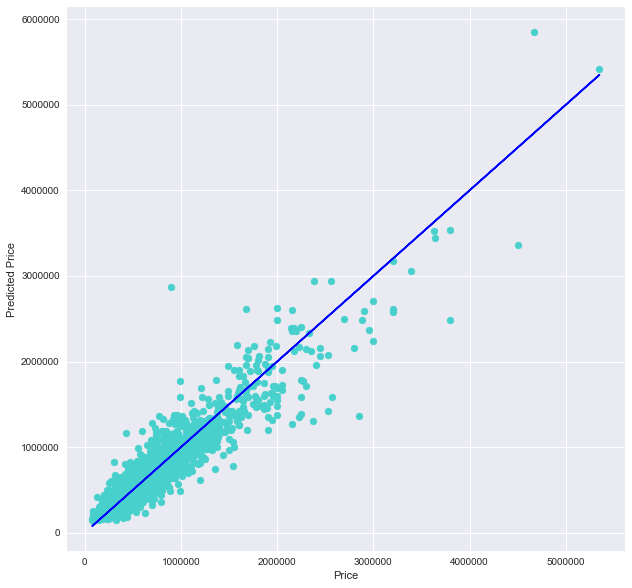

In [35]:
sns.set_style('darkgrid')
plt.scatter(y_test, xgb_y_test_pred, color='mediumturquoise')
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.plot(y_test,y_test,'b-') # identity line

In the graph above we can nicely see the price that was predicted and the price that the house actually cost. Points which are off the diagonal represent deviations from the true value. As we can see the learned model predicts the prices very accurately, with only few deviations.

In [36]:
fscores_xgb = xgboost_model.get_fscore()
fscores_xgb = {k.replace('_', '-'): v for k, v in fscores_xgb.items()}
fscores_xgb

{'bathrooms': 88,
 'bedrooms': 44,
 'condition': 60,
 'floors': 27,
 'grade': 148,
 'lat': 445,
 'long': 275,
 'sqft-above': 209,
 'sqft-basement': 120,
 'sqft-living': 279,
 'sqft-lot': 266,
 'view': 94,
 'waterfront': 58,
 'yr-built': 180,
 'yr-renovated': 43,
 'zipcode': 173}

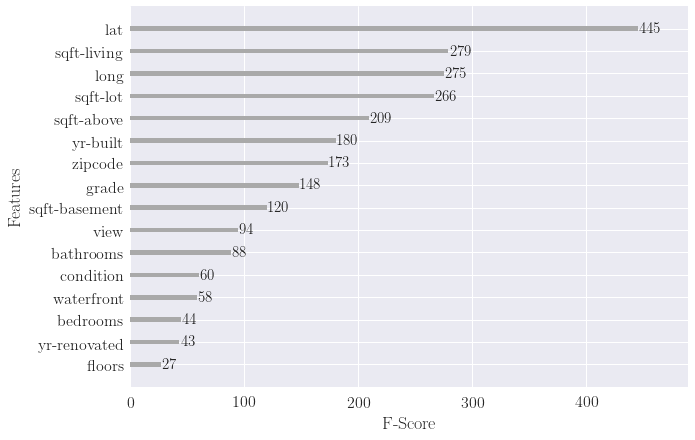

In [37]:
#Define the style of the plot
sns.set_style('darkgrid')

#Adjusting the Fonts to be able to use Latex, Note: Latex must be installed for this to work
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

#Adjusting the Writing size
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,1, figsize = (10,7))
xgb.plot_importance(fscores_xgb, ax = ax, color = 'darkgray')

#Add Axis titles
plt.title('')
plt.xlabel('F-Score', fontsize = 18)
plt.xticks(fontsize = 16)
plt.ylabel('Features', fontsize = 18) # ,fontsize = 18
plt.yticks(fontsize = 16)

#plt.savefig('XGB_Global_Feature_Importances.png', dpi = 200, bbox_inches = 'tight', format = 'png')

plt.show()

#Resetting Tex Formatting
plt.rc('text', usetex = False)

<b>SKLearn API:

In [38]:
#Importing the Gradient Boosted Trees Classifier
from sklearn.ensemble import GradientBoostingRegressor

#Building the XGB model
xgboost_model_skl = GradientBoostingRegressor(
    loss = 'ls',
    learning_rate = 0.10,
    n_estimators = 100,
    subsample = 0.8,
    criterion = 'friedman_mse',
    min_samples_split = 2,
    min_samples_leaf = 3,
    min_weight_fraction_leaf = 0.0,
    max_depth = 5,
    min_impurity_decrease = 0.0,
    min_impurity_split = None,
    init = None,
    random_state = 7,
    max_features = None,
    alpha = 0.9,
    verbose = 1,
    max_leaf_nodes = None,
    warm_start = False,
    presort = 'auto'
    )

#Fitting the XGB model
xgboost_model_skl.fit(X_train, y_train) #Unconment to retrain model

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 110867578547.2306 22118899727.6866            2.27s
         2 100135827191.1701 15253674772.9025            2.74s
         3 86982726160.8842 12332377329.9130            2.52s
         4 78317196109.6107  9407042973.5671            2.40s
         5 65368161244.2335 10088696566.1289            2.30s
         6 61644533395.2163  6110536645.1443            2.24s
         7 52281762331.6044  6265242272.3140            2.22s
         8 47593826494.5957  4757720157.5825            2.20s
         9 41139709223.3069  5284375816.7565            2.22s
        10 38734819861.0945  3562641036.3280            2.19s
        20 19924880692.3695   790027933.5430            1.92s
        30 14654805611.4088   244580561.8819            1.62s
        40 12076800407.6141   100214038.8025            1.36s
        50 11189368624.8216    31985402.7945            1.14s
        60  9941365878.5350     2660921.0818            0.90s
     

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=7,
             subsample=0.8, verbose=1, warm_start=False)

<b>Assessing the accuracy on training data:

In [39]:
xgb_skl_y_train_pred = xgboost_model_skl.predict(X_train)

In [40]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train,xgb_skl_y_train_pred))

90051.17059095837

In [41]:
from sklearn.metrics import r2_score
r2_score(y_train, xgb_skl_y_train_pred)

0.940106064191505

<b>Assessing the accuracy on testing data:

In [42]:
xgb_skl_y_test_pred = xgboost_model_skl.predict(X_test)

In [43]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, xgb_skl_y_test_pred))

121780.42964683089

In [44]:
from sklearn.metrics import r2_score
r2_score(y_test, xgb_skl_y_test_pred)

0.890019596597323

In [45]:
pd.options.display.float_format = '{:.1f}'.format
results = pd.DataFrame(y_test)
results['predicted'] = xgb_skl_y_test_pred
results.head()

,price,predicted
19320,370000.0,337376.1
16040,264500.0,263695.3
8731,630000.0,599939.4
2096,989000.0,1073250.3
4179,525000.0,549503.3


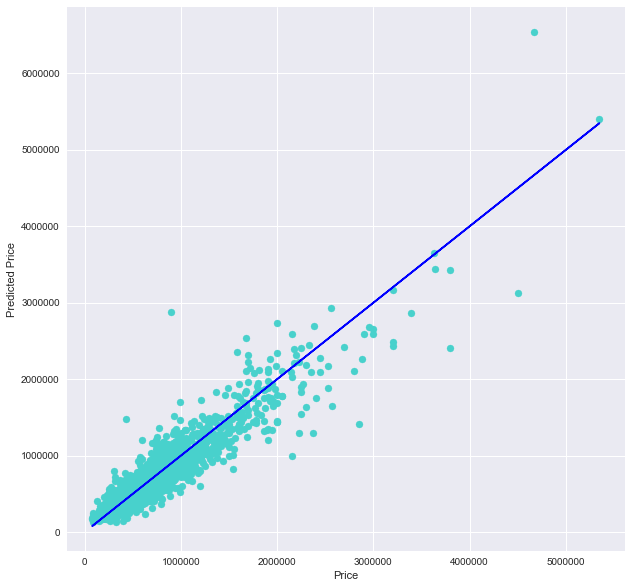

In [46]:
sns.set_style('darkgrid')
plt.scatter(y_test, xgb_skl_y_test_pred, color='mediumturquoise')
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.plot(y_test,y_test,'b-') # identity line

In the graph above we can nicely see the price that was predicted and the price that the house actually cost. Points which are off the diagonal represent deviations from the true value. As we can see the learned model predicts the prices very accurately, with only few deviations.

### LightGBM Fitting
[[Back to the top]](#Overview)

In [47]:
#Importing the model
import lightgbm as lgb

#Defining training and testing datasets
train_data = lgb.Dataset(X_train, label = y_train)
test_data = lgb.Dataset(X_test, label = y_test)

In [48]:
lgb_params = {'boost': 'gbdt',
              'num_leaves': 31,
              'max_depth': 5,
              'learning_rate': 0.01, #0.01 ist optimal
              'max_bin': 200,
              'objective': 'regression',
              'class_weight': None,
              'min_split_gain': 0.0,
              'min_child_weight': 0.001,
              'min_child_samples': 20, #20 ist optimal
              'subsample': 1.0,
              'subsample_freq': 1,
              'colsample_bytree': 1.0,
              'reg_alpha': 0.0,
              'reg_lambda': 0.0,
              'random_state': 77,
              'n_jobs': -1
             }

In [49]:
lgbm_model = lgb.train(lgb_params, train_data, num_boost_round = 50000)

### LightGBM Evaluation
[[Back to the top]](#Overview)

<b>Assessing the accuracy on training data:

In [50]:
lgbm_y_train_pred = lgbm_model.predict(X_train)

In [51]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, lgbm_y_train_pred))

105311.35954382826

In [52]:
from sklearn.metrics import r2_score
r2_score(y_train, lgbm_y_train_pred)

0.9180866728647755

<b>Assessing the accuracy on testing data:

In [53]:
lgbm_y_test_pred = lgbm_model.predict(X_test)

In [54]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, lgbm_y_test_pred))

133536.20346815602

In [55]:
from sklearn.metrics import r2_score
r2_score(y_test, lgbm_y_test_pred)

0.8677613661290505

In [56]:
pd.options.display.float_format = '{:.1f}'.format
results = pd.DataFrame(y_test)
results['predicted'] = lgbm_y_test_pred
results.head()

,price,predicted
19320,370000.0,347871.7
16040,264500.0,270635.3
8731,630000.0,570782.4
2096,989000.0,950242.3
4179,525000.0,530674.0


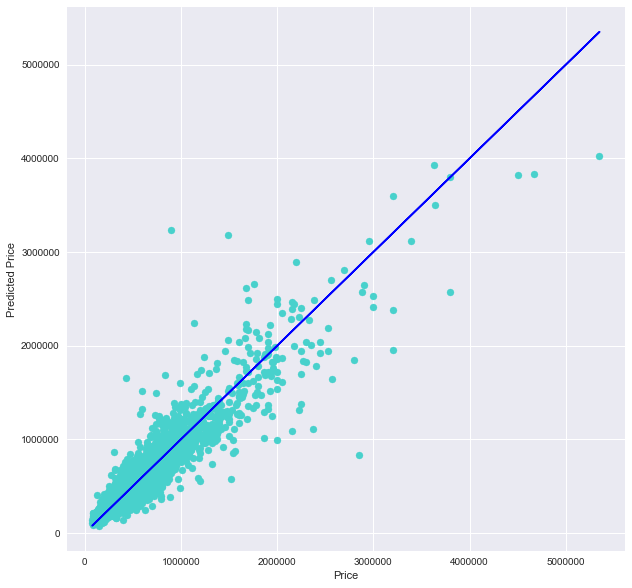

In [57]:
sns.set_style('darkgrid')
plt.scatter(y_test, lgbm_y_test_pred, color='mediumturquoise')
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.plot(y_test,y_test,'b-') # identity line

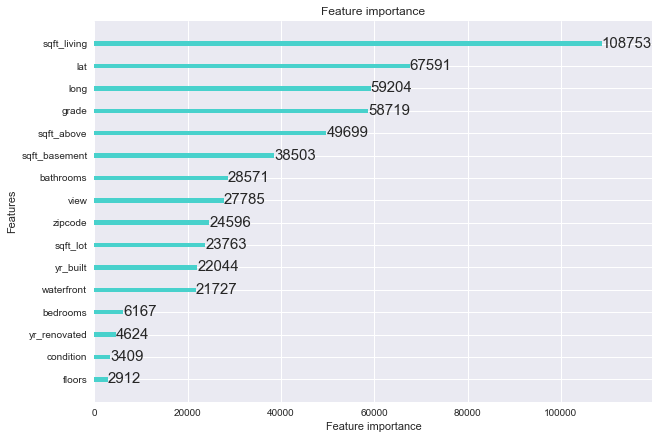

In [58]:
fig, ax = plt.subplots(1,1,figsize = (10,7))
lgb.plot_importance(lgbm_model, ax = ax, color = 'mediumturquoise')

## Explanation Models
[[Back to the top]](#Overview)

In the following we will construct the two previously used explanation models again: LIME and SHAP. We will first prepare the data to apply the explainers and then generate all explanations on the X_test for both techniques, to then finally check the algorithmic explanation consistency.

### LIME
[[Back to the top]](#Overview)

In [59]:
#Impoprting LIME Tabular Explainer & LabelEncoder
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder

In [60]:
#Creating XGB Test and Train arrays
xgb_train_lime = X_train.values
xgb_test_lime = X_test.values

#Defining Feature Names
xgb_feature_names = list(X_train.columns)

#Defining the Labels
xgb_labels = y_test.values

#Defining Class (label) Names
le = LabelEncoder()
le.fit(xgb_labels)
xgb_labels = le.transform(xgb_labels)
xgb_class_names = le.classes_

#Defining Categorical Features
xgb_categorical_features = [0,1,4,5,6,7,8,11,12,13]

#Generating all subclass names for each categorical feature
xgb_categorical_names = {}
for feature in xgb_categorical_features:
    le = LabelEncoder()
    le.fit(xgb_test_lime[:, feature])
    xgb_test_lime[:, feature] = le.transform(xgb_test_lime[:, feature])
    xgb_categorical_names[feature] = le.classes_

In [61]:
xgb_explainer = LimeTabularExplainer(xgb_train_lime,
                                     mode = 'regression', #or classification
                                     training_labels = y_train, #None, if we use discr. != entropy
                                     feature_names = xgb_feature_names,
                                     categorical_features = xgb_categorical_features,
                                     categorical_names = xgb_categorical_names,
                                     kernel_width = None, #Defaults to Sqrt(n_columns)*0,75
                                     verbose = False,
                                     class_names = xgb_class_names,
                                     feature_selection = 'auto',
                                     discretize_continuous = True,
                                     discretizer = 'entropy' #'quartile', 'decile' or 'entropy'
                                    )

In [62]:
#Set random seed for reproducibility of results
np.random.seed(7)
explain_object = 555 #Try 555 for all red, or 2 for all green
xgb_explanation = xgb_explainer.explain_instance(xgb_test_lime[explain_object],
                                                 xgboost_model_skl.predict,
                                                 labels=(1,),
                                                 top_labels = 1,
                                                 num_features = 18,
                                                 num_samples = 5000, #default 5000
                                                 distance_metric = 'manhattan', #to use for weighting samples
                                                 model_regressor = None
                                                )

In [63]:
xgboost_model_skl.predict(xgb_test_lime[explain_object].reshape(1, -1))

array([1036811.15659733])

In [64]:
X_test.iloc[555:556]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
19023,4,2.5,2230,3600,2.0,0,0,5,8,1630,600,1906,0,98112,47.6,-122.3


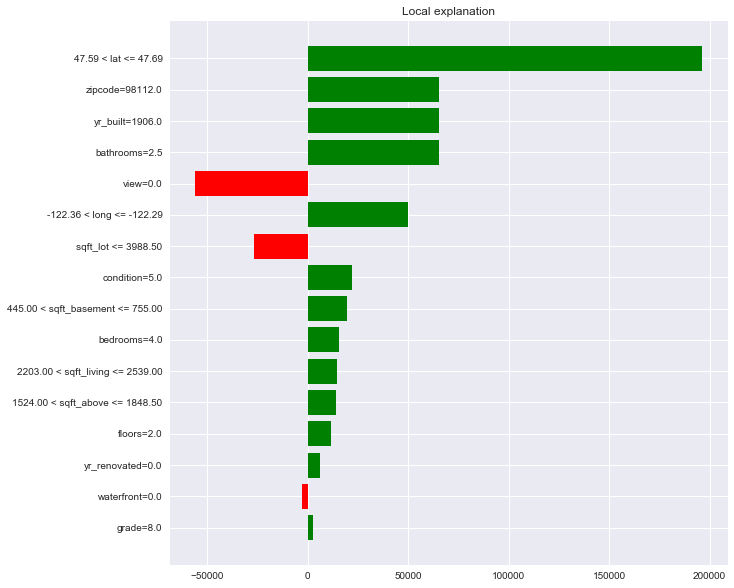

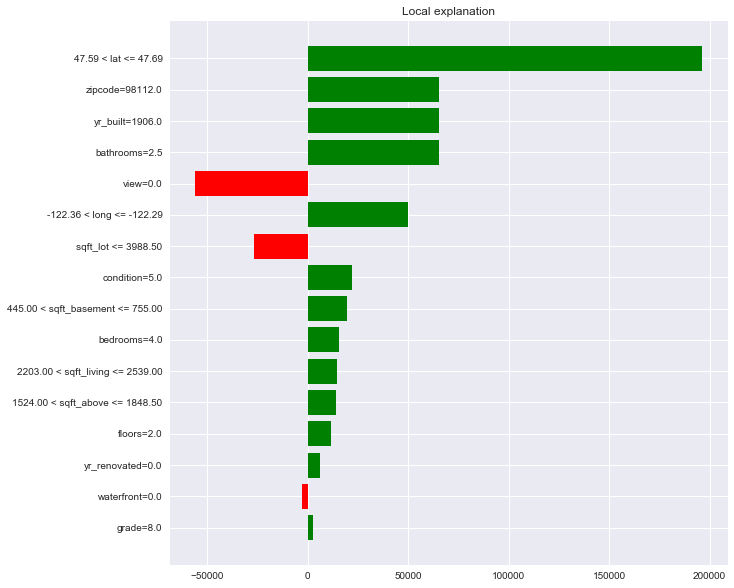

In [65]:
xgb_explanation.as_pyplot_figure()

In [66]:
pd.options.display.float_format = '{:.2f}'.format
xgb_explanation.as_map()[1] #Alwys use the [1] dict entry in the map, as it corresponds to the pyplot

[(14, 196362.41168800544),
 (13, 65193.49104063916),
 (11, 65193.491040639135),
 (1, 65193.49104063909),
 (6, -56135.07115794124),
 (15, 49750.92145297734),
 (3, -26583.84219161501),
 (7, 22227.780542824155),
 (10, 19638.502307751627),
 (0, 15698.677058650672),
 (2, 14659.687793015359),
 (9, 14012.990759139757),
 (4, 11489.74340727158),
 (12, 5902.41727072943),
 (5, -2841.638612909396),
 (8, 2817.0237047634623)]

The above values should be interpreted as follows: If a value is "green", then it means that if that particular house did not have that attribute, then it's predicted value would be lowered by the amount that it represents. In the opposite case for red bars, if that house did not have that, e.g. waterfront = 0, then then its predicted value would be increased by that attributes value. So green means how much it increased the value and red means how much it decreased the property value.

In [67]:
sum_total = 0
for i in range(len(X_test.columns)):
    sum_total = sum_total + xgb_explanation.as_map()[1][i][1]
sum_total    

462580.0771445805

In [68]:
xgb_explanation.score #R^2 value of the returned explanation

0.4060538108036665

<b>XGB LIME: Calculation of all Explanations:

In [69]:
#Creation of temporary dataframe to store the results of lime feature importances
xgb_lime_feat_imp_df = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, 'score'])

In [70]:
#Explainer function definition for Lime: Receives an index of a row and returns
#A list with feature indices and the respective feature importance
def xgb_lime_explain(object_index):
    np.random.seed(7) #To guarantee replicable results...
    xgb_explanation = xgb_explainer.explain_instance(
                                                 xgb_test_lime[object_index],
                                                 xgboost_model_skl.predict,
                                                 labels=(1,),
                                                 top_labels = 1,
                                                 num_features = 18,
                                                 num_samples = 5000,
                                                 distance_metric = 'manhattan',
                                                 model_regressor = None
                                                )
    
    return (xgb_explanation.as_map()[1], xgb_explanation.score)

In [71]:
#Definition of a function that writes the results from the function above into the lime_feat_imp_df
def xgb_lime_copy_to_df(object_index):
    feature_imp = xgb_lime_explain(object_index) #Call of explanation fct. to explain object of object_index
    
    for entry in feature_imp[0]:
        xgb_lime_feat_imp_df.loc[object_index, entry[0]] = entry[1] #This copies each value in the right column
        
    xgb_lime_feat_imp_df.loc[object_index, 'score'] = feature_imp[1] #This copies the score into the correct column

In [72]:
#To run the loop with a progress bar
from tqdm import tqdm

#Finally, a function to write all feature importances in the dataframe for 
for entry in tqdm(range(0,5)): #len(X_test)
    xgb_lime_copy_to_df(entry)
    #if entry == 10: break #For testing purposes    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


In [73]:
#Changing the names of the columns for better understanding later
xgb_lime_feat_imp_df.columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'score']
xgb_lime_feat_imp_df.columns = [str(col) + '_lime' for col in xgb_lime_feat_imp_df.columns]

#Printing the results
xgb_lime_feat_imp_df.tail()

,bedrooms_lime,bathrooms_lime,sqft_living_lime,sqft_lot_lime,floors_lime,waterfront_lime,view_lime,condition_lime,grade_lime,sqft_above_lime,sqft_basement_lime,yr_built_lime,yr_renovated_lime,zipcode_lime,lat_lime,long_lime,score_lime
0,-12238.59,-30188.85,-3572.90,-13130.84,-540.60,-3985.41,-61300.60,17068.46,-45446.98,17871.42,9724.18,-30188.85,-9387.21,-30188.85,-177551.48,1805.59,0.27
1,4177.34,-35181.40,-20059.99,-11649.49,-35181.40,-2737.21,-18190.11,-40949.77,-45025.52,-6192.91,9755.35,-35181.40,2858.05,-35181.40,-146598.61,3783.55,0.39
2,-6283.65,43610.72,36823.71,-53155.51,7144.29,-4967.40,-39477.33,-27455.86,34804.29,-5428.01,-8474.17,43610.72,4646.73,43610.72,60460.39,33434.59,0.13
3,1740.29,48253.22,130217.52,15436.50,2491.94,-6149.30,-31047.27,36542.41,-16200.27,36248.78,1889.16,48253.22,-1936.30,48253.22,72192.92,-27734.60,0.35
4,2144.34,5002.97,-7077.87,-5353.11,5287.92,-2323.70,-12770.88,1422.79,-11862.83,-4811.93,-15711.55,5287.92,1845.32,5287.92,120180.19,-16284.15,0.23


In [74]:
#Exporting and saving / importing results from above to avoid running multiple times...
import pickle
xgb_lime_results_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\xgb_lime_regr_results_16.sav'
#pickle.dump(xgb_lime_feat_imp_df, open(xgb_lime_results_fname, 'wb')) #Unconment to overwrite saved data

In [75]:
#Reload the Data...
loaded_xgb_lime_feat_imp_df = pickle.load(open(xgb_lime_results_fname, 'rb'))
loaded_xgb_lime_feat_imp_df.tail()

,bedrooms_lime,bathrooms_lime,sqft_living_lime,sqft_lot_lime,floors_lime,waterfront_lime,view_lime,condition_lime,grade_lime,sqft_above_lime,sqft_basement_lime,yr_built_lime,yr_renovated_lime,zipcode_lime,lat_lime,long_lime,score_lime
5350,-10078.84,4299.09,7536.52,454.93,4381.58,-2739.99,-26972.59,-983.36,3291.47,25077.86,12185.21,4381.58,-5970.68,4381.58,-1248.31,15942.20,0.02
5351,-5070.52,-7235.26,-73991.25,-24712.09,-6691.93,-9103.34,-63040.23,-18184.05,-11385.90,-36567.94,3310.98,-11385.90,-8628.82,-11385.90,-180691.05,18776.57,0.28
5352,3857.41,297.97,21166.03,5396.35,297.97,-1311.80,-4137.87,-3078.84,-14.49,-6899.61,-2547.62,297.97,-2029.29,297.97,18304.56,10886.91,0.03
5353,11347.73,22758.19,-33948.97,-24397.86,23122.60,-2758.09,-18793.87,-9712.47,20551.69,-2413.61,19311.07,23122.60,-466.82,23122.60,53915.96,38215.36,0.15
5354,-6786.92,-5538.03,-11967.63,38979.54,-531.52,-2914.82,-35625.96,-14529.58,-28928.01,119.37,6163.86,-5538.03,587.02,-5538.03,-92412.81,-42604.88,0.14


### SHAP
[[Back to the top]](#Overview)

In [76]:
#Impoprting shap
import shap

#Initializing javascript
shap.initjs()

In [77]:
#Generating the SHAP values for all objects in the test_set
xgb_shap_values = xgboost_model.predict(dvalid, pred_contribs = True)
xgb_shap_values

array([[ 2.06755356e+02,  1.75898724e+01, -2.07610977e+04, ...,
        -1.62857688e+05, -1.26080117e+04,  5.41223000e+05],
       [ 3.55484070e+02, -3.06826508e+02, -4.97608906e+04, ...,
        -1.89111719e+05,  1.85698789e+04,  5.41223000e+05],
       [-1.07981189e+03, -3.67678394e+03,  2.55769082e+04, ...,
         8.99021953e+04,  3.41632422e+04,  5.41223000e+05],
       ...,
       [-6.14318994e+03,  1.37958704e+03,  3.99755078e+04, ...,
        -2.33230249e+03,  3.21061621e+04,  5.41223000e+05],
       [ 5.46800720e+02, -3.76412012e+03, -9.14057422e+04, ...,
         1.22331555e+05,  1.97046289e+04,  5.41223000e+05],
       [ 1.25852936e+02,  1.09087486e+02, -4.04932383e+04, ...,
        -7.81151250e+04, -1.59112363e+04,  5.41223000e+05]], dtype=float32)

In [78]:
xgb_shap_values[1].shape

(17,)

In [79]:
object_to_exlain = 119 #Good Example for negative = 9; For positive = 119

In [80]:
X_test.iloc[object_to_exlain]

bedrooms            4.00
bathrooms           3.50
sqft_living      3610.00
sqft_lot         6345.00
floors              2.00
waterfront          0.00
view                0.00
condition           3.00
grade               9.00
sqft_above       2370.00
sqft_basement    1240.00
yr_built         2008.00
yr_renovated        0.00
zipcode         98058.00
lat                47.43
long             -122.10
Name: 20551, dtype: float64

In [81]:
y_test.iloc[object_to_exlain]

603000.0

In [82]:
xgb_predicted_prices = xgboost_model.predict(dvalid)
xgb_predicted_prices[object_to_exlain]

615484.1

In [83]:
sh_vals = pd.DataFrame(xgb_shap_values[object_to_exlain], index = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'base_value'])
dict(sh_vals)

{0: bedrooms           1567.87
 bathrooms         18009.80
 sqft_living      158464.97
 sqft_lot          -7385.95
 floors            -1039.22
 waterfront        -7656.60
 view             -12280.67
 condition         -9161.45
 grade             79951.01
 sqft_above         5381.35
 sqft_basement     10906.85
 yr_built          37244.14
 yr_renovated      -2141.26
 zipcode           -4728.45
 lat             -171783.86
 long             -21087.48
 base_value       541223.00
 Name: 0, dtype: float32}

In [84]:
y_test.mean()

539165.7985060691

In [85]:
#Plot
#Good Examples: 62, 5012, 
shap.force_plot(xgb_shap_values[object_to_exlain,:], X_test) #shap.LogitLink()

In [86]:
X_test.mean()

bedrooms            3.36
bathrooms           2.13
sqft_living      2083.92
sqft_lot        15119.09
floors              1.51
waterfront          0.01
view                0.23
condition           3.40
grade               7.66
sqft_above       1792.28
sqft_basement     291.64
yr_built         1971.81
yr_renovated       84.67
zipcode         98078.19
lat                47.56
long             -122.21
dtype: float64

In [87]:
X_test.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00
mean,3.36,2.13,2083.92,15119.09,1.51,0.01,0.23,3.40,7.66,1792.28,291.64,1971.81,84.67,98078.19,47.56,-122.21
std,0.91,0.77,915.12,40238.42,0.55,0.10,0.76,0.65,1.18,829.43,444.17,29.09,402.46,53.76,0.14,0.14
min,0.00,0.00,380.00,520.00,1.00,0.00,0.00,1.00,3.00,380.00,0.00,1900.00,0.00,98001.00,47.16,-122.51
25%,3.00,1.75,1430.00,5062.50,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1952.50,0.00,98033.00,47.47,-122.33
50%,3.00,2.25,1910.00,7573.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1976.00,0.00,98065.00,47.57,-122.23
75%,4.00,2.50,2550.00,10660.00,2.00,0.00,0.00,4.00,8.00,2220.00,570.00,1998.00,0.00,98117.00,47.68,-122.12
max,9.00,6.75,9640.00,982998.00,3.50,1.00,4.00,5.00,13.00,6720.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31


In [88]:
#Plot
shap.force_plot(xgb_shap_values[0:1000], X_test, link = 'identity') #shap.LogitLink()

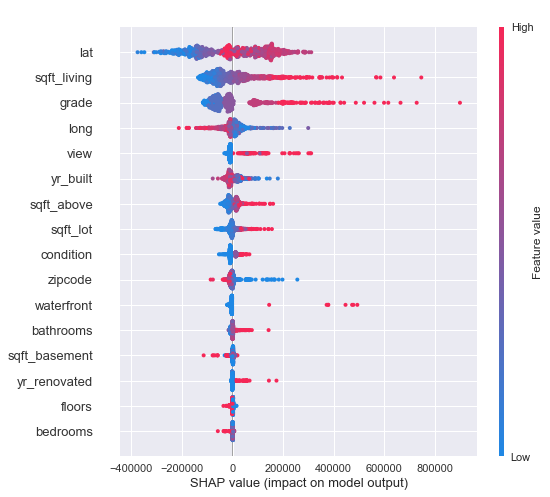

In [89]:
shap.summary_plot(xgb_shap_values[0:1000], X_test.iloc[0:1000])

<b>XGB SHAP: Calculation of all Explanations:

In [90]:
xgb_shap_values.shape

(5355, 17)

In [91]:
#Creation of temporary dataframe to store the results of lime feature importances
xgb_shap_values_untransformed_df = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [92]:
def xgb_get_shap_values(object_to_shap_explain):
    
    #Getting the untransformed shapley values
    shap_array = xgb_shap_values[object_to_shap_explain]
   
    #Now returning the array
    return shap_array

In [93]:
#Definition of a function that writes the results from the function above into the xgb_shap_values_untransformed_df
def xgb_shap_copy_to_df(object_index):
    shap_vals = xgb_get_shap_values(object_index) #Call fct. to get shap values of predicted class
    
    i = 0 #Helper variable to iterate the columns of the xgb_shap_values_df
    for entry in shap_vals:
        xgb_shap_values_untransformed_df.loc[object_index, i] = entry #This copies each value in the right column
        i += 1

In [94]:
#To run the loop with a progress bar
from tqdm import tqdm

#Finally, a function to write all feature importances in the dataframe for 
for entry in tqdm(range(0, 5)): #len(X_test)
    xgb_shap_copy_to_df(entry)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.71it/s]


In [95]:
#Changing the names of the columns for better understanding later
xgb_shap_values_untransformed_df.columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                                'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                                'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'base_value']
xgb_shap_values_untransformed_df.columns = [str(col) + '_shap' for col in xgb_shap_values_untransformed_df.columns]

#Printing the results
xgb_shap_values_untransformed_df.tail()

,bedrooms_shap,bathrooms_shap,sqft_living_shap,sqft_lot_shap,floors_shap,waterfront_shap,view_shap,condition_shap,grade_shap,sqft_above_shap,sqft_basement_shap,yr_built_shap,yr_renovated_shap,zipcode_shap,lat_shap,long_shap,base_value_shap
0,206.76,17.59,-20761.10,-5803.74,-371.02,-2185.43,-9724.22,31691.64,-8339.73,10766.18,706.64,-13207.17,-1048.66,3218.00,-162857.69,-12608.01,541223.00
1,355.48,-306.83,-49760.89,-5451.94,2543.92,-2208.12,-7841.45,-6891.47,-11052.17,-3756.58,1287.40,-13497.38,-1344.04,509.02,-189111.72,18569.88,541223.00
2,-1079.81,-3676.78,25576.91,-15488.23,563.10,-2147.78,-12083.51,13155.01,-89422.95,-2210.04,-6015.45,30171.55,-1031.01,-11640.82,89902.20,34163.24,541223.00
3,-7906.77,38493.84,229483.75,8630.63,-693.68,-18083.57,-20225.47,-11496.59,344388.16,48911.87,-9755.63,-14328.54,-5067.82,-13204.18,76254.70,-143346.72,541223.00
4,2042.79,-2721.66,810.35,-3584.59,2218.58,-2497.64,-13086.49,-10225.62,-22945.53,-12762.35,-7045.61,-13979.48,-1619.32,272.82,115192.34,-15134.72,541223.00


In [96]:
#Exporting and saving / importing results from above to avoid running multiple times...
import pickle
xgb_shap_untransf_results_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\xgb_shap_untransf_regr_results_16.sav'
#pickle.dump(xgb_shap_values_untransformed_df, open(xgb_shap_untransf_results_fname, 'wb')) #Unconment to overwrite saved data

In [97]:
#Reload the Data...
loaded_xgb_shap_values_untrans_df = pickle.load(open(xgb_shap_untransf_results_fname, 'rb'))
loaded_xgb_shap_values_untrans_df.tail()

,bedrooms_shap,bathrooms_shap,sqft_living_shap,sqft_lot_shap,floors_shap,waterfront_shap,view_shap,condition_shap,grade_shap,sqft_above_shap,sqft_basement_shap,yr_built_shap,yr_renovated_shap,zipcode_shap,lat_shap,long_shap,base_value_shap
5350,221.15,941.22,-21320.76,-1734.68,2112.99,-2508.54,-10533.14,-9126.29,-69817.22,14191.16,1027.53,-8028.25,-1249.46,-10012.69,-31488.99,21330.62,541223.00
5351,849.08,-6524.58,-70534.87,-7368.00,-213.55,-2012.64,-10346.65,12654.51,-66921.79,-11958.39,1070.91,-9048.47,-932.92,57175.40,-230640.62,21198.63,541223.00
5352,-6143.19,1379.59,39975.51,-781.69,2910.89,-2905.03,-11233.76,-11892.92,-72952.41,-12481.98,-21873.51,-19468.07,-1537.11,2750.86,-2332.30,32106.16,541223.00
5353,546.80,-3764.12,-91405.74,-40620.29,1302.73,-2030.45,-10461.41,13040.82,-70869.29,-27767.36,2827.63,25176.00,-896.66,-4688.03,122331.55,19704.63,541223.00
5354,125.85,109.09,-40493.24,18073.01,-725.55,-2587.91,-9014.05,-8553.92,636.50,-1162.49,1822.70,-14285.00,-1574.52,-1069.29,-78115.12,-15911.24,541223.00


## Algorithmic Explanation Consistency
[[Back to the top]](#Overview)

In this section we will verify the algorithmic explanation consistency for the regression case. We will start with LIME and analyse whether or better - how well it fulfills the three axioms for explanation consistency: Identity, Consistency and Stability. We will start by computing the distance matrix on the objects (i.e. on the X_test). As this matrix will be needed in the next steps to verify the axioms in conjunction with the distance matrices of the outputs (with shap and lime). There will be two versions of the object distance matrices: One that includes the prices and the other one which does not.

In [98]:
#We must start by standardizing the inputs, so we will use the StandardScaler
#Let's first compute the X_test_y_test which includes the inputs plus the labels
X_test_y_test = X_test.join(y_test)

#Applying the StandardScaler to the data
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(X_test_y_test.values)

scaled_inputs = pd.DataFrame(scaled_features, index = X_test_y_test.index, columns = X_test_y_test.columns)
scaled_inputs.tail()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
13567,-0.40,-0.49,-0.07,-0.16,-0.93,-0.10,-0.30,-0.62,-0.56,0.27,-0.66,-0.23,-0.21,-1.25,1.52,0.10,-0.37
5377,-0.40,-0.81,-0.88,-0.25,0.90,-0.10,-0.30,0.92,-1.41,-0.62,-0.66,0.38,-0.21,-1.42,-1.61,-0.03,-0.88
16322,1.80,0.48,0.59,-0.06,-0.93,-0.10,-0.30,-0.62,-0.56,-0.47,2.09,0.25,-0.21,-0.82,1.16,0.00,-0.57
3699,-1.49,-0.49,-0.83,-0.31,-0.93,-0.10,-0.30,0.92,-0.56,-1.05,0.24,-1.16,-0.21,0.72,0.93,-1.08,-0.32
2587,-0.40,0.48,-0.38,0.39,0.90,-0.10,-0.30,-0.62,0.28,-0.06,-0.66,0.69,-0.21,-0.62,-0.71,3.59,-0.44


In [99]:
scaled_inputs.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
count,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00
mean,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.69,-2.75,-1.86,-0.36,-0.93,-0.10,-0.30,-3.71,-3.94,-1.70,-0.66,-2.47,-0.21,-1.44,-2.85,-2.14,-1.26
25%,-0.40,-0.49,-0.71,-0.25,-0.93,-0.10,-0.30,-0.62,-0.56,-0.71,-0.66,-0.66,-0.21,-0.84,-0.67,-0.81,-0.60
50%,-0.40,0.15,-0.19,-0.19,-0.01,-0.10,-0.30,-0.62,-0.56,-0.28,-0.66,0.14,-0.21,-0.25,0.09,-0.11,-0.24
75%,0.70,0.48,0.51,-0.11,0.90,-0.10,-0.30,0.92,0.28,0.52,0.63,0.90,-0.21,0.72,0.86,0.63,0.27
max,6.19,5.97,8.26,24.06,3.64,10.41,4.97,2.47,4.51,5.94,10.20,1.48,4.80,2.25,1.58,6.37,13.10


In [100]:
scaled_inputs.shape

(5355, 17)

In [101]:
#Now we can proceed with calculating the distance matrix (based on the euclidean distance)
from scipy.spatial.distance import squareform, pdist
inputs_dm = pd.DataFrame(squareform(pdist(scaled_inputs)))
inputs_dm.head()

,0,1,2,3,4,5,6,7,8,9,...,5345,5346,5347,5348,5349,5350,5351,5352,5353,5354
0,0.00,3.94,4.98,6.77,4.84,5.41,5.21,4.87,4.27,5.34,...,13.39,4.16,6.51,5.45,5.32,4.76,3.00,5.71,4.85,4.67
1,3.94,0.00,5.07,6.96,4.09,5.62,4.98,4.62,4.20,4.37,...,12.97,3.57,5.21,4.92,5.82,4.31,3.70,5.15,4.58,4.45
2,4.98,5.07,0.00,7.86,3.81,6.48,3.48,4.71,5.27,4.14,...,12.93,6.26,5.33,3.72,5.72,4.63,5.06,3.95,3.37,6.72
3,6.77,6.96,7.86,0.00,7.02,3.19,7.76,5.80,6.28,9.18,...,15.99,9.21,10.67,8.16,5.00,7.23,8.51,7.01,8.91,6.33
4,4.84,4.09,3.81,7.02,0.00,5.38,4.45,4.58,3.95,4.99,...,13.55,5.15,5.74,4.57,5.89,2.95,4.46,2.34,4.25,4.76


In [102]:
#Now we can proceed with calculating the distance matrix (based on the euclidean distance)
from scipy.spatial.distance import squareform, pdist
inputs_dm_no_prices = pd.DataFrame(squareform(pdist(scaled_inputs.iloc[:,:-1])))
inputs_dm_no_prices.head()

,0,1,2,3,4,5,6,7,8,9,...,5345,5346,5347,5348,5349,5350,5351,5352,5353,5354
0,0.00,3.93,4.93,6.55,4.82,5.23,5.10,4.84,4.27,5.33,...,13.38,4.13,6.51,5.42,5.13,4.76,2.97,5.71,4.85,4.67
1,3.93,0.00,4.97,6.67,4.03,5.36,4.80,4.55,4.18,4.37,...,12.94,3.57,5.21,4.84,5.57,4.29,3.70,5.15,4.56,4.44
2,4.93,4.97,0.00,7.80,3.80,6.45,3.46,4.71,5.23,4.00,...,12.92,6.14,5.25,3.72,5.68,4.58,4.93,3.87,3.32,6.69
3,6.55,6.67,7.80,0.00,6.91,3.17,7.73,5.68,6.08,8.95,...,15.95,8.95,10.50,8.09,5.00,7.05,8.24,6.78,8.78,6.11
4,4.82,4.03,3.80,6.91,0.00,5.29,4.41,4.58,3.94,4.93,...,13.55,5.06,5.70,4.57,5.82,2.93,4.38,2.28,4.25,4.74


### LIME Evaluation
[[Back to the top]](#Overview)

<b>Preprocessing: Applying standardization to the lime explanations

In [103]:
#Applying the StandardScaler to the LIME explanations
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_lime_explanations = StandardScaler().fit_transform(loaded_xgb_lime_feat_imp_df.iloc[:,:-1].values)

scaled_lime_explanations = pd.DataFrame(scaled_lime_explanations,
                                        index = loaded_xgb_lime_feat_imp_df.iloc[:,:-1].index,
                                        columns = loaded_xgb_lime_feat_imp_df.iloc[:,:-1].columns)
scaled_lime_explanations.tail()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,bedrooms_lime,bathrooms_lime,sqft_living_lime,sqft_lot_lime,floors_lime,waterfront_lime,view_lime,condition_lime,grade_lime,sqft_above_lime,sqft_basement_lime,yr_built_lime,yr_renovated_lime,zipcode_lime,lat_lime,long_lime
5350,-1.10,-0.14,0.17,-0.10,0.13,0.10,-0.10,0.12,0.54,1.10,0.58,-0.13,-0.42,-0.13,-0.12,0.49
5351,-0.65,-0.52,-1.19,-1.08,-0.46,-0.48,-1.27,-0.55,0.11,-1.90,-0.16,-0.63,-0.68,-0.63,-1.71,0.59
5352,0.16,-0.27,0.39,0.09,-0.09,0.23,0.64,0.04,0.45,-0.46,-0.65,-0.26,-0.04,-0.26,0.05,0.31
5353,0.83,0.47,-0.52,-1.06,1.13,0.10,0.17,-0.22,1.05,-0.24,1.17,0.46,0.11,0.46,0.37,1.30
5354,-0.80,-0.46,-0.16,1.39,-0.13,0.08,-0.38,-0.40,-0.41,-0.11,0.08,-0.45,0.21,-0.45,-0.93,-1.62


In [104]:
scaled_lime_explanations.describe()

,bedrooms_lime,bathrooms_lime,sqft_living_lime,sqft_lot_lime,floors_lime,waterfront_lime,view_lime,condition_lime,grade_lime,sqft_above_lime,sqft_basement_lime,yr_built_lime,yr_renovated_lime,zipcode_lime,lat_lime,long_lime
count,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00
mean,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.50,-1.88,-1.85,-2.52,-2.31,-3.51,-2.60,-1.98,-2.81,-2.79,-4.25,-1.80,-4.73,-1.80,-1.91,-2.62
25%,-0.51,-0.72,-0.80,-0.54,-0.61,-0.18,-0.52,-0.70,-0.48,-0.67,-0.50,-0.80,-0.33,-0.80,-0.82,-0.65
50%,-0.07,-0.13,-0.07,-0.10,-0.09,0.05,-0.15,-0.18,-0.01,-0.13,-0.01,-0.09,-0.01,-0.09,0.11,0.05
75%,0.41,0.51,0.51,0.35,0.46,0.19,0.22,0.59,0.64,0.59,0.49,0.55,0.21,0.55,0.53,0.70
max,14.19,9.61,4.20,5.85,11.05,27.40,9.31,10.90,7.46,8.82,11.94,9.18,18.31,9.18,2.08,6.80


In [105]:
scaled_lime_explanations.shape

(5355, 16)

<b>Distance Matrix: Computing the distance matrix between all lime explanations

In [106]:
#Now we can proceed with calculating the distance matrix (based on the euclidean distance)
from scipy.spatial.distance import squareform, pdist
lime_explanations_dm = pd.DataFrame(squareform(pdist(scaled_lime_explanations)))
lime_explanations_dm.head()

,0,1,2,3,4,5,6,7,8,9,...,5345,5346,5347,5348,5349,5350,5351,5352,5353,5354
0,0.00,3.96,6.36,6.08,4.88,6.91,7.36,4.46,3.83,4.29,...,3.87,3.44,3.97,5.33,6.23,3.30,3.76,4.20,5.51,3.68
1,3.96,0.00,6.47,7.28,4.91,7.66,7.42,5.22,3.99,3.54,...,3.64,3.15,3.47,5.91,7.43,4.56,3.79,4.00,5.61,3.98
2,6.36,6.47,0.00,5.37,4.13,7.56,5.64,4.19,3.98,5.14,...,4.65,5.72,5.03,4.18,4.55,4.30,5.15,4.10,3.74,6.00
3,6.08,7.28,5.37,0.00,4.54,3.61,5.45,3.43,4.76,7.13,...,5.40,6.41,6.69,4.93,4.30,4.28,7.18,4.57,5.46,5.09
4,4.88,4.91,4.13,4.54,0.00,5.53,5.44,3.68,3.44,4.33,...,2.95,3.79,3.67,4.28,4.82,3.51,4.64,1.98,4.15,3.61


<b>Algorithmic Explanation Consistency: Computing the distance matrix between all lime explanations

<b>1: Identity:</b> Identical inputs must have identical outputs:

In [107]:
%%latex
\begin{align}
D_{x_(i,j)} = 0 \implies D_{\varepsilon_(i,j)} = 0, \\
\forall i, j \\
\end{align}

<IPython.core.display.Latex object>

In [108]:
#Defining a function to navigate around the distance matrix
oks = 0
errors = 0
i_dm = inputs_dm.values #Computations on np.arrays are faster than on dataframes
l_e_dm = lime_explanations_dm.values

#To run the loop with a progress bar
from tqdm import tqdm
for column in tqdm(inputs_dm):
    for row in inputs_dm:
        if i_dm[row, column] == 0: #If two inputs have distance 0, then their explanations must too
            if l_e_dm[row, column] == 0:
                oks += 1
            else:
                errors += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5355/5355 [00:18<00:00, 282.80it/s]


In [109]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5355 Erorrs: 0

Axiom 1 Stats:
Fulfilled in: 5355 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


As we can see, there are 5355 cases in which the inputs_dm had a 0 and consequently, the lime_explanations_dm was also 0. This is easily explained, as the entries on the diagonal of a distance matrix are always 0 (the distance of a point to itself). In the following, we also provide an easy workaround to check whether there could be a case of different explanations for the same input.

In [110]:
(inputs_dm == 0).sum(axis=1).sum()

5355

In [111]:
(lime_explanations_dm == 0).sum().sum()

5489

So in sum, LIME fulfills this first axiom, however, to completely verify the first axiom, a duplicated input must be given to lime to see whether it generates an identical explanation. From manual tests, we have found out that this is only the case if we provide it the same seed value everytime. Due to the probabilistic nature in sampling the local neighborhood of lime, it can unfortunately also not fully fulfill this first axiom.

Moreover, as we can see above, the lime_explanations_dm has more 0's than the inputs_dm, which seems to already imply some consequences for the second axiom... Let's find out!

<b>2: Separability:</b> Non-identical inputs cannot have identical outputs:

In [112]:
%%latex
\begin{align}
D_{x_(i,j)} > 0 \implies D_{\varepsilon_(i,j)} > 0, \\
\forall i, j \\
\end{align}

<IPython.core.display.Latex object>

In [113]:
#Defining a function to navigate around the distance matrix
oks = 0
errors = 0
i_dm = inputs_dm.values #Computations on np.arrays are faster than on dataframes
l_e_dm = lime_explanations_dm.values

#To run the loop with a progress bar
from tqdm import tqdm
for column in tqdm(inputs_dm):
    for row in inputs_dm:
        if i_dm[row, column] > 0: #If two inputs have distance > 0, then their explanations must too
            if l_e_dm[row, column] > 0:
                oks += 1
            else:
                errors += 1
        #else:
        #    oks += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5355/5355 [00:39<00:00, 134.45it/s]


In [114]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 2 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 28670536 Erorrs: 134

Axiom 2 Stats:
Fulfilled in: 28670536 Cases
Not fulfilled in: 134 Cases
Relative Fulfillment: 99.9995326212248 %


In [115]:
(lime_explanations_dm != 0).sum().sum()

28670536

In [116]:
(lime_explanations_dm == 0).sum().sum()

5489

In [117]:
print((lime_explanations_dm != 0).sum().sum() + (lime_explanations_dm == 0).sum().sum())

28676025


In [118]:
((lime_explanations_dm >=0 ).sum().sum())

28676025

In [119]:
print(oks + errors)

28670670


As we can see above, the sum of oks + errors yields 28670670, which is exactly correct, as the second axiom applies to all cells in the DM, where no 0-entries are. As we have seen in Axiom 1, there are 5355 cells with 0's, in them... So if we sum 28670670 + 5355 = 28676025, which is exactly right.

<b>Sanity Checks

In [120]:
pd.options.display.max_rows = 130 #default is 60

In [121]:
scaled_lime_explanations[scaled_lime_explanations.duplicated(keep=False)].tail()

,bedrooms_lime,bathrooms_lime,sqft_living_lime,sqft_lot_lime,floors_lime,waterfront_lime,view_lime,condition_lime,grade_lime,sqft_above_lime,sqft_basement_lime,yr_built_lime,yr_renovated_lime,zipcode_lime,lat_lime,long_lime
4978,-0.12,0.34,-1.24,-1.37,0.88,-0.05,-0.07,0.29,0.39,-1.07,0.18,0.32,-0.17,0.32,0.32,0.27
5005,-0.05,-0.44,1.93,-0.53,0.23,0.01,-0.29,-0.64,-2.37,0.71,-1.77,-0.42,0.28,-0.42,0.43,-1.37
5065,0.69,0.19,-0.92,-1.18,0.53,-0.04,0.04,0.17,0.33,-0.15,-0.76,0.11,-0.46,0.11,0.29,0.17
5328,0.50,0.56,-0.03,-1.22,1.25,0.07,0.09,0.71,0.82,0.03,0.13,0.53,0.59,0.53,0.30,1.27
5330,-0.44,-1.03,-0.53,-0.98,-1.30,0.13,0.38,-0.72,-0.38,-1.19,-0.85,-0.98,0.25,-0.98,0.17,0.84


In [122]:
X_test_y_test.iloc[[24,819,1023,1619,59,3991,1529,1660,433,1907]]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
10040,4,2.50,2506,7206,2.00,0,0,3,8,2506,0,2007,0,98023,47.32,-122.34,350000.00
7350,4,2.50,2441,7316,2.00,0,0,3,8,2441,0,2007,0,98023,47.32,-122.34,340000.00
16247,2,1.75,1210,1161,2.00,0,0,3,8,1210,0,2014,0,98029,47.55,-122.00,395000.00
4736,2,1.75,1210,1040,2.00,0,0,3,8,1210,0,2014,0,98029,47.55,-122.00,357186.00
20401,3,2.25,1400,3814,2.00,0,0,3,7,1400,0,2012,0,98042,47.36,-122.08,250000.00
20145,3,2.25,1400,3825,2.00,0,0,3,7,1400,0,2012,0,98042,47.36,-122.08,270000.00
3363,2,2.00,1760,7200,1.00,0,0,5,7,880,880,1946,0,98118,47.57,-122.28,579000.00
4462,3,3.25,1370,1194,3.00,0,0,3,8,1370,0,2004,0,98107,47.67,-122.39,469000.00
20001,3,2.50,1780,1729,2.00,0,0,3,8,1080,700,2008,0,98103,47.66,-122.36,660000.00
20147,3,2.50,1780,1647,2.00,0,0,3,8,1080,700,2008,0,98103,47.66,-122.36,672000.00


In [123]:
scaled_lime_explanations.iloc[[24,819,1023,1619,59,3991,1529,1660,433,1907]]

,bedrooms_lime,bathrooms_lime,sqft_living_lime,sqft_lot_lime,floors_lime,waterfront_lime,view_lime,condition_lime,grade_lime,sqft_above_lime,sqft_basement_lime,yr_built_lime,yr_renovated_lime,zipcode_lime,lat_lime,long_lime
24,0.33,-1.29,0.15,-0.25,-0.40,-0.15,-0.88,-1.44,-1.25,0.04,0.16,-1.24,-0.26,-1.24,-1.61,0.41
819,0.33,-1.29,0.15,-0.25,-0.40,-0.15,-0.88,-1.44,-1.25,0.04,0.16,-1.24,-0.26,-1.24,-1.61,0.41
1023,0.38,-0.62,-1.46,-1.45,-0.01,-0.15,-0.29,-0.52,-0.47,-0.96,-0.52,-0.57,0.19,-0.57,0.26,-1.41
1619,0.38,-0.62,-1.46,-1.45,-0.01,-0.15,-0.29,-0.52,-0.47,-0.96,-0.52,-0.57,0.19,-0.57,0.26,-1.41
59,0.38,-0.98,-0.96,-1.60,-0.63,-0.00,-0.26,-1.07,-0.18,-0.61,-0.31,-0.94,-0.90,-0.94,-1.43,-0.98
3991,0.38,-0.98,-0.96,-1.60,-0.63,-0.00,-0.26,-1.07,-0.18,-0.61,-0.31,-0.94,-0.90,-0.94,-1.43,-0.98
1529,0.38,0.05,-0.29,0.29,0.43,0.16,0.18,0.35,0.65,-0.42,-0.97,0.05,0.16,0.05,0.20,-0.07
1660,0.36,0.13,-0.91,-1.31,0.55,-0.18,-0.14,0.39,0.53,-0.40,-0.44,0.12,-0.16,0.12,1.36,1.33
433,0.36,0.71,-0.33,-0.99,-0.19,0.13,-0.20,0.92,0.66,-0.87,0.88,0.67,0.72,0.67,1.52,0.70
1907,0.36,0.71,-0.33,-0.99,-0.19,0.13,-0.20,0.92,0.66,-0.87,0.88,0.67,0.72,0.67,1.52,0.70


<b>3: Stability:</b> Similar inputs must result in similar outputs:

In [124]:
%%latex
\begin{align}
\rho(D_{x_j}, D_{e_j}) = \rho_j = 1, \\
\forall j \in n \\
\end{align}

<IPython.core.display.Latex object>

In [125]:
#Importing packages
from scipy.stats import spearmanr

#Creating a list that contains all Spearman's Rhos rank correlation coefficients
sp_rhos_lime = list()

#Creating a function that computes all Rhos
for column in tqdm(inputs_dm):
    sp_rho = spearmanr(inputs_dm.iloc[:,column], lime_explanations_dm.iloc[:,column])
    sp_rhos_lime.append(sp_rho[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5355/5355 [00:15<00:00, 337.26it/s]


In [126]:
len(sp_rhos_lime)

5355

In [127]:
oks = 0
errors = 0
for entry in sp_rhos_lime:
    if entry >= 0:
        oks += 1
    else:
        errors += 1

In [128]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5351 Erorrs: 4

Axiom 3 Stats:
Fulfilled in: 5351 Cases
Not fulfilled in: 4 Cases
Relative Fulfillment: 99.9252476172678 %


In [129]:
sp_rhos_lime = pd.Series(sp_rhos_lime)
print('Rho_max:',sp_rhos_lime.max(), 'Rho_min:', sp_rhos_lime.min())
print('Rho_mean:', sp_rhos_lime.mean(), 'Rho_median:', sp_rhos_lime.median())

Rho_max: 0.8001216974656091 Rho_min: -0.008588598057885807
Rho_mean: 0.49021629296501235 Rho_median: 0.5036528640619842


In [130]:
column = sp_rhos_lime.idxmin()
sp_rho = spearmanr(inputs_dm.iloc[:,column], lime_explanations_dm.iloc[:,column])
sp_rho

SpearmanrResult(correlation=-0.008588598057885807, pvalue=0.5297680438699214)

In [131]:
column = sp_rhos_lime.idxmax()
sp_rho = spearmanr(inputs_dm.iloc[:,column], lime_explanations_dm.iloc[:,column])
sp_rho

SpearmanrResult(correlation=0.8001216974656091, pvalue=0.0)

As we can see above, the spearman's rhos are also not adding up to 1. This means too, that the third axiom is only partially fulfilled. 
Now let's see how the SHAP explanations hold up against that... 

Moreover, the p-value tells us how likely we are to do a mistake by rejecting the null-hypothesis (H0: There is no [monotonic] association between the two variables [in the population]).
<br>For more information check:
- https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.spearmanr.html
- https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide-2.php

### SHAP Evaluation
[[Back to the top]](#Overview)

<b>Preprocessing: Applying standardization to the lime explanations

In [132]:
#Applying the StandardScaler to the SHAP explanations
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_shap_explanations = StandardScaler().fit_transform(loaded_xgb_shap_values_untrans_df.iloc[:,:-1].values)

scaled_shap_explanations = pd.DataFrame(scaled_shap_explanations,
                                        index = loaded_xgb_shap_values_untrans_df.iloc[:,:-1].index,
                                        columns = loaded_xgb_shap_values_untrans_df.iloc[:,:-1].columns)
scaled_shap_explanations.tail()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,bedrooms_shap,bathrooms_shap,sqft_living_shap,sqft_lot_shap,floors_shap,waterfront_shap,view_shap,condition_shap,grade_shap,sqft_above_shap,sqft_basement_shap,yr_built_shap,yr_renovated_shap,zipcode_shap,lat_shap,long_shap
5350,0.11,0.04,-0.19,-0.02,0.50,-0.06,-0.26,-0.57,-0.55,0.60,0.18,-0.43,-0.14,-0.44,-0.21,0.40
5351,0.22,-0.56,-0.61,-0.25,-0.10,-0.05,-0.25,0.93,-0.53,-0.46,0.19,-0.47,-0.11,2.23,-1.66,0.40
5352,-0.98,0.07,0.34,0.02,0.70,-0.07,-0.27,-0.76,-0.58,-0.48,-2.90,-0.90,-0.17,0.07,-0.00,0.65
5353,0.16,-0.34,-0.79,-1.60,0.29,-0.05,-0.25,0.96,-0.56,-1.11,0.42,0.94,-0.11,-0.23,0.91,0.36
5354,0.09,-0.03,-0.35,0.79,-0.23,-0.06,-0.22,-0.53,0.04,-0.02,0.29,-0.69,-0.17,-0.08,-0.55,-0.46


In [133]:
scaled_shap_explanations.describe()

,bedrooms_shap,bathrooms_shap,sqft_living_shap,sqft_lot_shap,floors_shap,waterfront_shap,view_shap,condition_shap,grade_shap,sqft_above_shap,sqft_basement_shap,yr_built_shap,yr_renovated_shap,zipcode_shap,lat_shap,long_shap
count,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00,5355.00
mean,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-18.25,-2.22,-1.25,-3.55,-20.42,-0.76,-0.80,-3.92,-0.99,-2.43,-15.36,-4.69,-0.58,-7.87,-3.56,-5.40
25%,0.10,-0.44,-0.61,-0.30,-0.24,-0.08,-0.28,-0.63,-0.56,-0.60,0.03,-0.66,-0.16,-0.38,-0.90,-0.36
50%,0.19,-0.10,-0.32,-0.07,0.15,-0.05,-0.24,-0.50,-0.35,-0.16,0.23,-0.30,-0.14,-0.17,0.09,0.04
75%,0.26,0.04,0.31,0.14,0.45,-0.05,-0.21,0.81,-0.03,0.54,0.32,0.63,-0.12,0.01,0.86,0.42
max,4.39,18.16,21.01,9.54,5.99,18.74,9.74,6.66,10.01,16.61,8.36,8.15,18.02,10.14,2.65,8.38


In [134]:
scaled_shap_explanations.shape

(5355, 16)

<b>Distance Matrix: Computing the distance matrix between all shap explanations

In [135]:
#Now we can proceed with calculating the distance matrix (based on the euclidean distance)
from scipy.spatial.distance import squareform, pdist
shap_explanations_dm = pd.DataFrame(squareform(pdist(scaled_shap_explanations)))
shap_explanations_dm.head()

,0,1,2,3,4,5,6,7,8,9,...,5345,5346,5347,5348,5349,5350,5351,5352,5353,5354
0,0.00,2.94,3.43,7.14,3.90,5.52,3.71,3.15,3.20,3.60,...,8.12,2.23,4.57,4.64,5.67,3.25,2.96,4.92,3.82,3.07
1,2.94,0.00,3.47,7.22,2.71,5.41,3.67,1.96,1.99,2.09,...,7.92,1.39,2.95,3.79,5.50,1.57,2.85,3.77,3.64,1.72
2,3.43,3.47,0.00,7.59,2.95,6.01,2.13,3.02,2.47,2.85,...,8.22,3.18,2.87,2.47,5.32,2.81,4.21,3.79,2.23,3.57
3,7.14,7.22,7.59,0.00,6.59,4.86,7.62,6.67,6.63,7.91,...,11.53,7.30,8.68,7.72,7.64,6.90,8.51,7.12,8.36,6.48
4,3.90,2.71,2.95,6.59,0.00,4.50,3.21,2.43,1.95,2.73,...,8.41,2.66,2.91,3.35,5.26,2.20,4.12,2.89,3.35,2.31


<b>Algorithmic Explanation Consistency: Computing the distance matrix between all lime explanations

<b>1: Identity:</b> Identical inputs must have identical outputs:

In [136]:
%%latex
\begin{align}
D_{x_(i,j)} = 0 \implies D_{\varepsilon_(i,j)} = 0, \\
\forall i, j \\
\end{align}

<IPython.core.display.Latex object>

In [137]:
#Defining a function to navigate around the distance matrix
oks = 0
errors = 0
i_dm = inputs_dm.values #Computations on np.arrays are faster than on dataframes
s_e_dm = shap_explanations_dm.values

#To run the loop with a progress bar
from tqdm import tqdm
for column in tqdm(inputs_dm):
    for row in inputs_dm:
        if i_dm[row, column] == 0: #If two inputs have distance 0, then their explanations must too
            if l_e_dm[row, column] == 0:
                oks += 1
            else:
                errors += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5355/5355 [00:18<00:00, 296.96it/s]


In [138]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5355 Erorrs: 0

Axiom 1 Stats:
Fulfilled in: 5355 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


As we can see, there are 5404 cases in which the inputs_dm had a 0 and consequently, the shap_explanations_dm was also 0. This is easily explained, as the entries on the diagonal of a distance matrix are always 0 (the distance of a point to itself). In the following, we also provide an easy workaround to check whether there could be a case of different explanations for the same input.

In [139]:
(inputs_dm == 0).sum(axis=1).sum()

5355

In [140]:
(shap_explanations_dm == 0).sum(axis=1).sum()

5383

So in sum, SHAP fulfills this first axiom, however, to completely verify the first axiom, a duplicated input must be given to lime to see whether it generates an identical explanation. From manual tests, we have found out that this is  the case even withoutpriving the algorithm a seed value at all. Due to its non-probabilistic nature it can thus, fully fulfill this first axiom.

Moreover, as we can see above, the shap_explanations_dm has more 0's than the inputs_dm, which seems to already imply some consequences for the second axiom... Let's find out!

<b>2: Separability:</b> Non-identical inputs cannot have identical outputs:

In [141]:
%%latex
\begin{align}
D_{x_(i,j)} > 0 \implies D_{\varepsilon_(i,j)} > 0, \\
\forall i, j \\
\end{align}

<IPython.core.display.Latex object>

In [142]:
#Defining a function to navigate around the distance matrix
oks = 0
errors = 0
i_dm = inputs_dm.values #Computations on np.arrays are faster than on dataframes
s_e_dm = shap_explanations_dm.values

#To run the loop with a progress bar
from tqdm import tqdm
for column in tqdm(inputs_dm):
    for row in inputs_dm:
        if i_dm[row, column] > 0: #If two inputs have distance 0, then their explanations must too
            if s_e_dm[row, column] > 0:
                oks += 1
            else:
                errors += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5355/5355 [00:38<00:00, 138.92it/s]


In [143]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 28670642 Erorrs: 28

Axiom 1 Stats:
Fulfilled in: 28670642 Cases
Not fulfilled in: 28 Cases
Relative Fulfillment: 99.99990233912446 %


In [144]:
shap_explanations_dm.duplicated().value_counts()

False    5341
True       14
dtype: int64

In [145]:
(inputs_dm != 0).sum(axis=1).sum()

28670670

In [146]:
(shap_explanations_dm != 0).sum(axis=1).sum()

28670642

As we can see above, we get 14 errors in the verification of our 2. Axiom. This means that shap sometimes generates the exactly same explanations for different objects, which should obviously not happen... So as expected, the second axiom is only partially fulfilled.

<b>3: Stability:</b> Similar inputs must result in similar outputs:

In [147]:
%%latex
\begin{align}
\rho(D_{x_j}, D_{e_j}) = \rho_j = 1, \\
\forall j \in n \\
\end{align}

<IPython.core.display.Latex object>

In [148]:
#Creating a list that contains all Spearman's Rhos rank correlation coefficients
sp_rhos_shap = list()

#Creating a function that computes all Rhos
for column in tqdm(inputs_dm):
    sp_rho = spearmanr(inputs_dm.iloc[:,column], shap_explanations_dm.iloc[:,column])
    sp_rhos_shap.append(sp_rho[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5355/5355 [00:14<00:00, 359.41it/s]


In [149]:
oks = 0
errors = 0
for entry in sp_rhos_shap:
    if entry >= 0:
        oks += 1
    else:
        errors += 1

In [150]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5355 Erorrs: 0

Axiom 3 Stats:
Fulfilled in: 5355 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


In [151]:
sp_rhos_shap = pd.Series(sp_rhos_shap)
print('Rho_max:',sp_rhos_shap.max(), 'Rho_min:', sp_rhos_shap.min())
print('Rho_mean:', sp_rhos_shap.mean(), 'Rho_median:', sp_rhos_shap.median())

Rho_max: 0.8934249718614607 Rho_min: 0.16847937690605724
Rho_mean: 0.7019903102252516 Rho_median: 0.7149779738383651


As we can see above, the spearman's rhos are also not adding up to 1, however, they are much better than the ones from lime. This means too, that the third axiom is only partially fulfilled. 
Now let's see how the SHAP explanations hold up against that... 

In [152]:
column = sp_rhos_shap.idxmin() #try 69, 429
sp_rho = spearmanr(inputs_dm.iloc[:,column], shap_explanations_dm.iloc[:,column])
sp_rho

SpearmanrResult(correlation=0.16847937690605724, pvalue=2.1688896613586344e-35)

In [153]:
column = sp_rhos_shap.idxmax() #try 69, 429
sp_rho = spearmanr(inputs_dm.iloc[:,column], shap_explanations_dm.iloc[:,column])
sp_rho

SpearmanrResult(correlation=0.8934249718614607, pvalue=0.0)

### AEC Heuristic
[[Back to the top]](#Overview)

In this chapter, we will finally try out how well the approximative procedure works on the data (even though the data is small enough to apply the exact procedure). We will start with the lime results and proceed with the results from shap. To analyse the similarities, we will use the Jaccard-Coefficient.

<b>Definition of the Jaccard Similarity:

In [154]:
from math import*
#Defining the jaccard_similarity to compute similarities between the clusters
def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    result = 0
    try:
        result = intersection_cardinality / float(union_cardinality)
    except:
        result = 0
    return result

#Creating a function that computes the most similar clusters comparing objects and explanations
def compute_cluster_similarities(object_clustering_df, explanation_clustering_df):
    '''This function has 2 arguments:
    - object_clustering_df = dataframe with index and in the first column the assigned cluster to that object
    - explanation_clustering_df: corresponding explanation df with clusters for each object in the df above
    return value is a dictionary, which assigns to each object cluster the most similar explanation cluster.
    Note: the #Clusters must be equal in each dataframe.'''
    
    #First we must determine the number of clusters in either of the two df in the arguments
    nclusters = len(object_clustering_df.iloc[:,0].unique())
    
    #This function creates a list of lists, whereas each sublist contains the indices of all objects in that cluster
    objects_list = list()
    explanations_list = list()
    for cluster in range(nclusters):
        objects_list.append(list(object_clustering_df[object_clustering_df.iloc[:,0] == cluster].index)) 
        explanations_list.append(list(explanation_clustering_df[explanation_clustering_df.iloc[:,0] == cluster].index))
    
    #This function computes the jaccard_similarities for all cluster combinations
    js_similarities = dict()
    for i in range(nclusters):
        for j in range(nclusters):
            js_similarities[i,j] = jaccard_similarity(objects_list[i], explanations_list[j])
    
    #This function determines which clusters have the highest similarity amongst each other
    cluster_similarities = dict()
    max_probab = 0
    a_helper = 0
    b_helper = 0
    for i in range(nclusters):
        for j in range(nclusters):
            if js_similarities[i,j] > max_probab:
                max_probab = js_similarities[i,j]
                a_helper = i
                b_helper = j
        cluster_similarities[a_helper, b_helper] = max_probab
        max_probab = 0
    
    #Return the dictionary which contains the clusters with the highest similarities
    return cluster_similarities

<b>Data Binning:

In [155]:
from astropy.stats import histogram
hist = histogram(scaled_inputs['price'].values, bins = 10) #try 'blocks' and 'knuth'

In [156]:
hist[0]

array([3844, 1224,  178,   69,   22,   10,    3,    2,    2,    1],
      dtype=int64)

In [157]:
scaled_inputs['bin'] = np.digitize(scaled_inputs['price'].values, hist[1])

In [158]:
scaled_inputs.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price,bin
19320,-0.40,0.48,-0.11,-0.20,0.90,-0.10,-0.30,2.47,0.28,0.23,-0.66,0.66,-0.21,-0.88,-1.17,0.21,-0.46,1
16040,-0.40,0.48,-0.50,-0.17,-0.93,-0.10,-0.30,-0.62,0.28,-0.20,-0.66,0.63,-0.21,0.26,-2.13,-0.04,-0.75,1
8731,0.70,-0.17,0.43,-0.28,-0.01,-0.10,-0.30,0.92,-0.56,-0.39,1.62,-1.92,-0.21,0.70,0.07,-1.27,0.25,2
2096,1.80,3.06,2.13,-0.04,0.90,-0.10,-0.30,-0.62,2.82,2.70,-0.66,0.97,-0.21,-0.06,0.16,1.55,1.22,2
4179,0.70,-0.49,0.04,-0.18,-0.93,-0.10,-0.30,-0.62,0.28,-0.69,1.37,-0.23,-0.21,-1.32,0.30,0.49,-0.04,1


<b>Clustering on Lime Explanations:

In [159]:
scaled_lime_explanations.columns

Index(['bedrooms_lime', 'bathrooms_lime', 'sqft_living_lime', 'sqft_lot_lime',
       'floors_lime', 'waterfront_lime', 'view_lime', 'condition_lime',
       'grade_lime', 'sqft_above_lime', 'sqft_basement_lime', 'yr_built_lime',
       'yr_renovated_lime', 'zipcode_lime', 'lat_lime', 'long_lime'],
      dtype='object')

In [160]:
#Model definition
from sklearn.cluster import KMeans
lime_xgb_explanations_kmeans = KMeans(n_clusters = len(hist[0]),
                              init = 'k-means++',
                              n_init = 20,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 7,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [161]:
%%time
#Applying the above model to the scaled_lime_xgb_explanations
lime_xgb_explanations_kmeans_results = lime_xgb_explanations_kmeans.fit(scaled_lime_explanations)

Wall time: 2.63 s


In [162]:
lime_xgb_explanations_kmeans_classes = pd.DataFrame(lime_xgb_explanations_kmeans_results.labels_)
lime_xgb_explanations_kmeans_classes[0].value_counts()#.head(10)

8    1293
0     909
5     871
7     720
2     709
3     494
9     238
6      78
4      22
1      21
Name: 0, dtype: int64

In [163]:
scaled_inputs['bin'].value_counts()#.head(10)

1     3844
2     1224
3      178
4       69
5       22
6       10
7        3
9        2
8        2
11       1
Name: bin, dtype: int64

In [164]:
compute_cluster_similarities(pd.DataFrame(scaled_inputs['bin']), lime_xgb_explanations_kmeans_classes)

{(0, 0): 0,
 (1, 8): 0.04538054538054538,
 (2, 8): 0.02567237163814181,
 (3, 6): 0.011857707509881422,
 (4, 7): 0.006377551020408163,
 (5, 0): 0.003232758620689655,
 (6, 3): 0,
 (9, 2): 0.0014084507042253522}

<b>Clustering on Shap Explanations:

In [165]:
scaled_shap_explanations.columns

Index(['bedrooms_shap', 'bathrooms_shap', 'sqft_living_shap', 'sqft_lot_shap',
       'floors_shap', 'waterfront_shap', 'view_shap', 'condition_shap',
       'grade_shap', 'sqft_above_shap', 'sqft_basement_shap', 'yr_built_shap',
       'yr_renovated_shap', 'zipcode_shap', 'lat_shap', 'long_shap'],
      dtype='object')

In [166]:
#Model definition
from sklearn.cluster import KMeans
shap_xgb_explanations_kmeans = KMeans(n_clusters = len(hist[0]),
                              init = 'k-means++',
                              n_init = 20,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 7,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [167]:
%%time
#Applying the above model to the scaled_lime_xgb_explanations
shap_xgb_explanations_kmeans_results = shap_xgb_explanations_kmeans.fit(scaled_shap_explanations)

Wall time: 2.69 s


In [168]:
shap_xgb_explanations_kmeans_classes = pd.DataFrame(shap_xgb_explanations_kmeans_results.labels_)
shap_xgb_explanations_kmeans_classes[0].value_counts()#.head(10)

1    1715
4    1117
7    1036
3     883
6     179
5     130
2     108
9      81
8      70
0      36
Name: 0, dtype: int64

In [169]:
scaled_inputs['bin'].value_counts()#.head(10)

1     3844
2     1224
3      178
4       69
5       22
6       10
7        3
9        2
8        2
11       1
Name: bin, dtype: int64

In [170]:
compute_cluster_similarities(pd.DataFrame(scaled_inputs['bin']), shap_xgb_explanations_kmeans_classes)

{(0, 0): 0,
 (1, 1): 0.05443854324734446,
 (2, 1): 0.03522367030644593,
 (3, 1): 0.010138740661686232,
 (4, 7): 0.004545454545454545,
 (5, 4): 0.003524229074889868,
 (6, 3): 0,
 (9, 1): 0.0005827505827505828}

<b>BACKUP:

In [171]:
X_train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00,16065.00
mean,3.38,2.11,2082.71,15154.17,1.49,0.01,0.24,3.41,7.66,1790.80,291.91,1970.82,84.84,98077.75,47.56,-122.21
std,0.94,0.77,920.81,41982.72,0.54,0.08,0.77,0.65,1.17,829.18,442.45,29.47,402.63,53.38,0.14,0.14
min,0.00,0.00,290.00,572.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52
25%,3.00,1.50,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1951.00,0.00,98033.00,47.47,-122.33
50%,3.00,2.25,1920.00,7620.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23
75%,4.00,2.50,2550.00,10713.00,2.00,0.00,0.00,4.00,8.00,2220.00,560.00,1996.00,0.00,98117.00,47.68,-122.12
max,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4130.00,2015.00,2015.00,98199.00,47.78,-121.31


In [172]:
X_test.iloc[9:11]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
17727,3,1.00,1040,6860,2.00,0,0,3,6,1040,0,1942,0,98146,47.51,-122.38
3733,4,2.75,3470,212639,2.00,0,0,3,7,2070,1400,1993,0,98019,47.71,-121.97


In [173]:
y_test.mean()

539165.7985060691